In [ ]:
import numpy as np
import matplotlib.pylab as plt
from dataset import Dataset
from soft_dtw import SoftDTW
from soft_dtw import jacobian_sq_euc
import numpy as np
from scipy.optimize import minimize


def softdtw_barycenter(X_list, Z_init, gamma=1.0, max_iter=50, tol=1e-3, weights=None):
    """
    Compute the Soft-DTW barycenter of a list of time series.
    Reformulated version compatible with the user's SoftDTW class.
    """

    # correction : X_list is the correct name
    if X_list is None or len(X_list) == 0:
        raise ValueError("X_list must contain at least one time series.")

    if weights is None:
        weights = np.ones(len(X_list))  # uniform weights
    
    else : 
        weights = np.array(weights)

    T, d = Z_init.shape

    def objective(Z_flat):
        Z = Z_flat.reshape(T, d)
        total_cost = 0.0
        total_grad = np.zeros_like(Z)

        for w, X in zip(weights, X_list):

            # Step 1: Distance matrix Z vs X
            D = SoftDTW.squared_euclidean_distances(None, Z, X)

            # Step 2: Soft-DTW forward + backward
            sdtw = SoftDTW(D, gamma=gamma)
            cost = sdtw.compute()
            E = sdtw._soft_dtw_grad()

            # Step 3: Gradient wrt Z
            G = jacobian_sq_euc(None, Z, X, E)

            total_cost += w * cost
            total_grad += w * G

        return total_cost, total_grad.ravel()

    # Optimization
    res = minimize(
        fun=objective,
        x0=Z_init.ravel(),
        method="L-BFGS-B",
        jac=True,
        tol=tol,
        options={"maxiter": max_iter, "disp": False},
    )

    return res.x.reshape(T, d)





In [26]:
ds = Dataset("Gun_Point")
X_tr, y_tr, X_te, y_te = ds.load_ucr()

rng = np.random.default_rng(seed=42)

idx1 = rng.choice(np.where(y_tr == 1)[0])
idx2 = rng.choice(np.where(y_tr == 1)[0])

X1 = X_tr[idx1]
X2 = X_tr[idx2]



first_case = X1*0.25 + X2*0.75
second_case = X1*0.5 + X2*0.5
third_case = X1*0.75 + X2*0.25

barycenter_1 = softdtw_barycenter([X1, X2], first_case, gamma=1.0, max_iter=100, weights=[0.25, 0.75])
barycenter_2 = softdtw_barycenter([X1, X2], second_case, gamma=1.0, max_iter=100, weights=[0.5, 0.5])
barycenter_3 = softdtw_barycenter([X1, X2], third_case, gamma=1.0, max_iter=100, weights=[0.75, 0.25])




Loading UCR dataset: Gun_Point
Path train: /Users/ilan/sdtw_data/UCR_TS_Archive_2015/Gun_Point/Gun_Point_TRAIN
Path test: /Users/ilan/sdtw_data/UCR_TS_Archive_2015/Gun_Point/Gun_Point_TEST


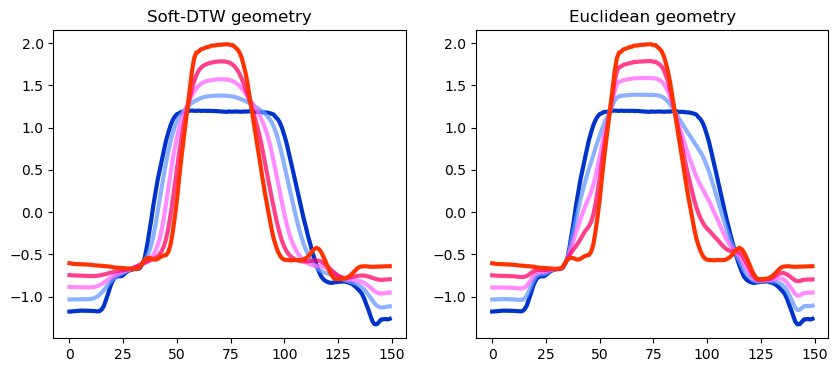

In [27]:
colors = [
    (0, 51./255, 204./255),
    (102./255, 153./255, 255./255),
    (255./255, 102./255, 255./255),
    (255./255, 0, 102./255),
    (1.0, 51./255, 0),
]


fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)

ax.plot(X1.ravel(), c=colors[0], lw=3)
ax.plot(barycenter_3, c=colors[1], lw=3, alpha=0.75)
ax.plot(barycenter_2, c=colors[2], lw=3, alpha=0.75)
ax.plot(barycenter_1, c=colors[3], lw=3, alpha=0.75)
ax.plot(X2.ravel(), c=colors[4], lw=3)
ax.set_title("Soft-DTW geometry")

ax = fig.add_subplot(122)

ax.plot(X1.ravel(), c=colors[0], lw=3)
ax.plot(third_case, c=colors[1], lw=3, alpha=0.75)
ax.plot(second_case, c=colors[2], lw=3, alpha=0.75)
ax.plot(first_case, c=colors[3], lw=3, alpha=0.75)
ax.plot(X2.ravel(), c=colors[4], lw=3)
ax.set_title("Euclidean geometry")

plt.show()
